In [1]:
!pip install -q tensorflow transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 106.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.5 MB/s eta 0:00:00


In [112]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from transformers import TFBertModel, BertTokenizer

In [70]:
df = pd.read_csv('ielts_writing_dataset.csv')

# Exploratory data analysis

In [71]:
print("Shape:", df.shape)
df.head(3)

Shape: (1435, 9)


,Task_Type,Question,Essay,Examiner_Commen,Task_Response,Coherence_Cohesion,Lexical_Resource,Range_Accuracy,Overall
0,1,The bar chart below describes some changes abo...,"Between 1995 and 2010, a study was conducted r...",NaN,NaN,NaN,NaN,NaN,5.5
1,2,Rich countries often give money to poorer coun...,Poverty represents a worldwide crisis. It is t...,NaN,NaN,NaN,NaN,NaN,6.5
2,1,The bar chart below describes some changes abo...,The left chart shows the population change hap...,NaN,NaN,NaN,NaN,NaN,5.0


In [72]:
df.describe()

,Task_Type,Task_Response,Coherence_Cohesion,Lexical_Resource,Range_Accuracy,Overall
count,1435.000000,0.0,0.0,0.0,0.0,1435.000000
mean,1.552613,NaN,NaN,NaN,NaN,6.550174
std,0.497397,NaN,NaN,NaN,NaN,1.058237
min,1.000000,NaN,NaN,NaN,NaN,1.000000
25%,1.000000,NaN,NaN,NaN,NaN,6.000000
50%,2.000000,NaN,NaN,NaN,NaN,6.500000
75%,2.000000,NaN,NaN,NaN,NaN,7.000000
max,2.000000,NaN,NaN,NaN,NaN,9.000000


In [73]:
df = df.rename(columns={'Examiner_Commen': 'Comment'})

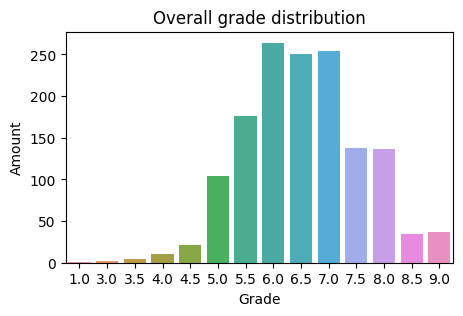

In [74]:
# Assuming 'column_name' is the name of the column you want to plot
plt.figure(figsize=(5, 3))
sns.countplot(data=df, x='Overall')
plt.title(f'Overall grade distribution')
plt.xlabel('Grade')
plt.ylabel('Amount')
plt.show()


Let's drop the samples whose label appears only ones, so we are able to stratify it.

In [75]:
df = df[df['Overall'].map(df['Overall'].value_counts()) > 1]

Check for the amount of examiners comments, to decide if they are in a meaningful amount for training or not.


In [76]:
# Group by "Overall" and count non-None values in "Comment"
df[df['Comment'].notna()].groupby("Overall")["Comment"].count()

Overall
5.0     8
6.0    24
7.0    17
8.0    13
Name: Comment, dtype: int64

Check for the amount of questions not provided.

In [77]:
df['Question'].isna().sum()

0

##Feature engineering
Now we explore the correlation between the essay's length and the grade.

<ipython-input-78-afc8180eb243>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Length"]=df["Essay"].apply(lambda x: len(x.split(" ")))


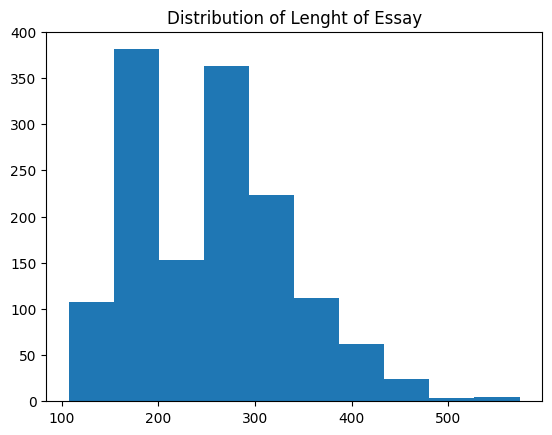

In [78]:
df["Length"]=df["Essay"].apply(lambda x: len(x.split(" ")))
plt.hist(df["Length"])
plt.title("Distribution of Lenght of Essay")
plt.show()

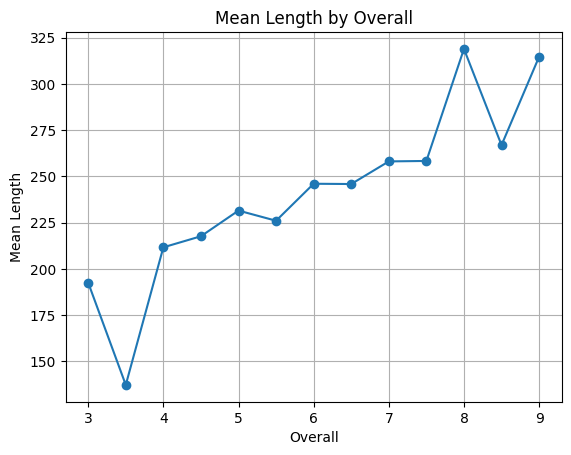

In [79]:
# Group by "Overall" and calculate the mean of "Length"
result = df.groupby(["Overall"]).agg({"Length":"mean"})

# Reset the index to make "Overall" a regular column
result.reset_index(inplace=True)

# Create a line plot
plt.plot(result["Overall"], result["Length"], marker='o', linestyle='-')
plt.xlabel("Overall")
plt.ylabel("Mean Length")
plt.title("Mean Length by Overall")
plt.grid(True)
plt.show()

In [80]:
# Transform the 'Category' column to 0s and 1s
df['Task_Type'] = (df['Task_Type'] == 2).astype(int)

# Perform one-hot encoding
df = pd.get_dummies(df, columns=['Task_Type'], prefix=['Task_Type'])

#Data preparation
After the data exploration decided to keep 3 data configurations:
1. BERT with only essay text (text)
2. BERT with essay text concatenated with length feature (text + numerical)
3. BERT with essay text concatenated with length and task type (text + numerical + binary)

3rd option is not preferable for deployment because user must choose also the task number => less user friendly.

The Question data are dropped because it would be harder for a user to insert also a quesion text to the website.

In [81]:
# All changeable variables are stored in a config dictionary for easier access
config ={
    "max_seq_length": 512,
    "bert_model_name": "bert-base-uncased",
    "learning_rate": 0.001,
    "batch_size": 32,
    "epochs": 50,
    "loss": 'mean_squared_error',
    "metrics": [MeanAbsoluteError(), RootMeanSquaredError()],
}

In [82]:
# Load pre-trained BERT model and tokenizer
bert_tokenizer = BertTokenizer.from_pretrained(config['bert_model_name'])
bert_model = TFBertModel.from_pretrained(config['bert_model_name'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [83]:
# Extract chosen data
X = df[['Essay',
        'Length',
        'Task_Type_0',
        'Task_Type_1']]

y = df['Overall']

# Define the indexes for different feature types
text_colums_indexes = 0
numerical_columns_indexes = [1]
binary_columns_indexes = [2, 3]

In [84]:
# Separate train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X.values, y,
    test_size=0.1,
    shuffle=True,
    stratify=y,
    random_state=42
)

In [85]:
# Extract features
text_features_train = X_train[:, text_colums_indexes]
text_features_val = X_val[:, text_colums_indexes]

numerical_features_train = X_train[:, numerical_columns_indexes]
numerical_features_val = X_val[:, numerical_columns_indexes]

binary_features_train = X_train[:, binary_columns_indexes]
binary_features_val = X_val[:, binary_columns_indexes]

In [86]:
# Tokenize the text features with padding and truncation
input_ids_train = bert_tokenizer(list(text_features_train), padding=True, truncation=True, return_tensors='tf', max_length=config['max_seq_length'])['input_ids']
input_ids_val = bert_tokenizer(list(text_features_val), padding=True, truncation=True, return_tensors='tf', max_length=config['max_seq_length'])['input_ids']

In [113]:
# Standartize the numerical data
scaler = StandardScaler()
numerical_features_train_std = scaler.fit_transform(numerical_features_train)
numerical_features_val_std = scaler.transform(numerical_features_val)

# Save the scaler to a file
with open('scaler_config.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [88]:
# Gather all the features to one dictionary
X_train_dict = {
    "input_ids": input_ids_train,
    "numerical_features": numerical_features_train_std.astype(np.float32),
    "binary_features": binary_features_train.astype(np.float32)
}

X_val_dict = {
    "input_ids": input_ids_val,
    "numerical_features": numerical_features_val_std.astype(np.float32),
    "binary_features": binary_features_val.astype(np.float32)
}

# Defining the models

### 1st model type:
- Text

In [89]:
# Create a custom regression head
regression_head = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='linear')
])

# Combine BERT and Regression Head
input_ids = tf.keras.layers.Input(shape=(config['max_seq_length'],), dtype=tf.int32)
bert_output = bert_model(input_ids)[0]  # BERT's output
pooler_output = bert_output[:, 0, :]     # Pooler output
regression_output = regression_head(pooler_output)  # Custom regression head

bert_text_model = tf.keras.models.Model(inputs=input_ids, outputs=regression_output)

# Set BERT layers as non-trainable
for layer in bert_model.layers:
    layer.trainable = False

# Compile the model, specifying the loss and metrics
bert_text_model.compile(optimizer=tf.keras.optimizers.Adam(config['learning_rate']),
    loss=config['loss'],
    metrics=config['metrics'])

# Print model summary
bert_text_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 512)]             0         
                                                                 
 tf_bert_model_1 (TFBertMod  TFBaseModelOutputWithPo   109482240 
 el)                         olingAndCrossAttentions             
                             (last_hidden_state=(Non             
                             e, 512, 768),                       
                              pooler_output=(None, 7             
                             68),                                
                              past_key_values=None,              
                             hidden_states=None, att             
                             entions=None, cross_att             
                             entions=None)                       
                                                           

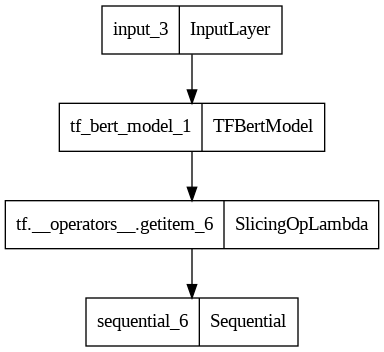

In [90]:
tf.keras.utils.plot_model(bert_text_model)

### 2nd model type:
- Text
- Numerical

In [91]:
# Define input layers
input_ids = tf.keras.layers.Input(shape=(config['max_seq_length'],), dtype=tf.int32, name="input_ids")
numerical_features = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name="numerical_features")

# BERT embedding layer
bert_output = bert_model(input_ids)[0]  # BERT's output
pooler_output = bert_output[:, 0, :]    # Pooler output

# Combine BERT output with numerical features
concatenated_features = tf.keras.layers.concatenate([pooler_output, numerical_features])

# Custom regression head
regression_head = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='linear')
])

# Connect regression head to combined features
regression_output = regression_head(concatenated_features)

# Create the final model
bert_num_model = tf.keras.models.Model(inputs=[input_ids, numerical_features], outputs=regression_output)

# Set BERT layers as non-trainable
for layer in bert_model.layers:
    layer.trainable = False

# Compile the model
bert_num_model.compile(optimizer=tf.keras.optimizers.Adam(config['learning_rate']),
    loss=config['loss'],
    metrics=config['metrics'])

# Print model summary
bert_num_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 tf_bert_model_1 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]']           
 el)                         ngAndCrossAttentions(last_   40                                      
                             hidden_state=(None, 512, 7                                           
                             68),                                                                 
                              pooler_output=(None, 768)                                           
                             , past_key_values=None, hi                                     

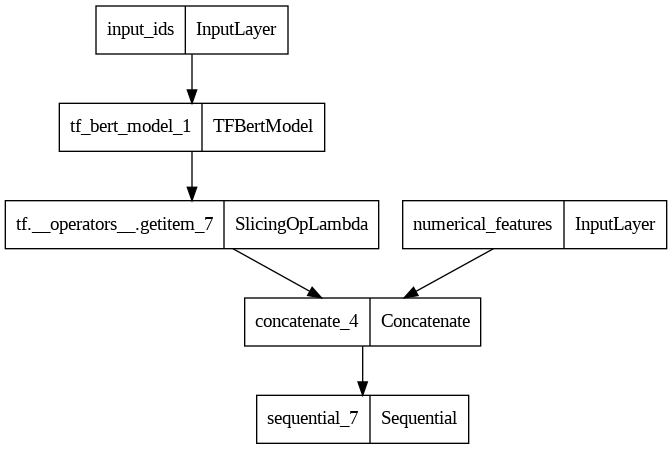

In [92]:
tf.keras.utils.plot_model(bert_num_model)

### 3rd model type:
- Text
- Numerical
- Binary

In [93]:
# Define input layers
input_ids = tf.keras.layers.Input(shape=(config['max_seq_length'],), dtype=tf.int32, name="input_ids")
numerical_features = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name="numerical_features")
binary_features = tf.keras.layers.Input(shape=(2,), dtype=tf.float32, name="binary_features")

# BERT embedding layer
bert_output = bert_model(input_ids)[0]  # BERT's output
pooler_output = bert_output[:, 0, :]     # Pooler output

# Combine BERT output with numerical features
concatenated_features = tf.keras.layers.concatenate([pooler_output, numerical_features, binary_features])

# Custom regression head
regression_head = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='linear')
])

# Connect regression head to combined features
regression_output = regression_head(concatenated_features)

# Create the final model
bert_num_binary_model = tf.keras.models.Model(inputs=[input_ids, numerical_features, binary_features], outputs=regression_output)

# Set BERT layers as non-trainable
for layer in bert_model.layers:
    layer.trainable = False

# Compile the model
bert_num_binary_model.compile(optimizer=tf.keras.optimizers.Adam(config['learning_rate']),
    loss=config['loss'],
    metrics=config['metrics'])

# Print model summary
bert_num_binary_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 tf_bert_model_1 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]']           
 el)                         ngAndCrossAttentions(last_   40                                      
                             hidden_state=(None, 512, 7                                           
                             68),                                                                 
                              pooler_output=(None, 768)                                           
                             , past_key_values=None, hi                                     

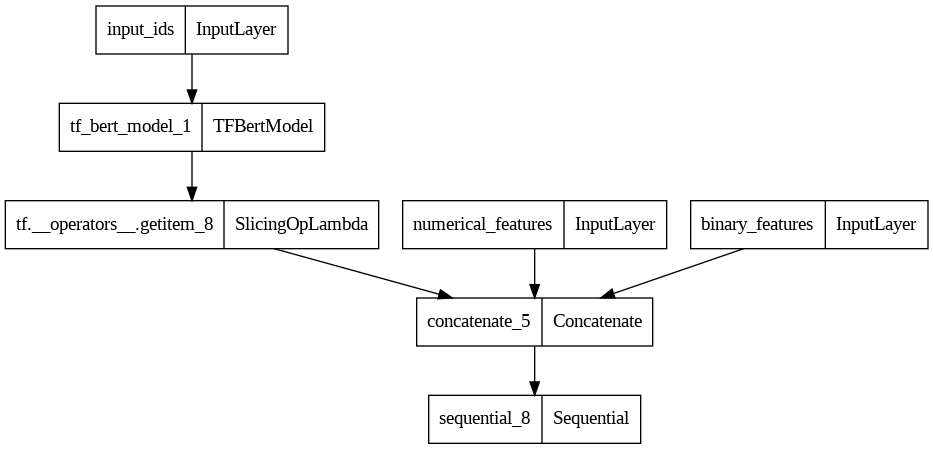

In [94]:
tf.keras.utils.plot_model(bert_num_binary_model)

# Training

In [95]:
# Define a callback to perform early stopping
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    min_delta=0,         # Minimum change in validation loss to be considered an improvement
    patience=3,          # Number of epochs with no improvement after which training will stop
    verbose=0,           # Verbosity mode (0 for silent)
    mode='auto'          # Automatically infer the direction of loss improvement
)

In [96]:
# Define a callback to save the model with the lowest validation loss
checkpoint_callback_bert = tf.keras.callbacks.ModelCheckpoint(
    filepath='training_bert_text/cp.ckpt',  # Specify the path to save the best model
    monitor='val_loss',       # Monitor validation loss
    save_best_only=True,      # Save only the best model (lowest val_loss)
    mode='min',               # Consider lower values as better
    verbose=1                 # Verbosity mode (0 for silent)
)

history_bert = bert_text_model.fit(X_train_dict['input_ids'], y_train,
    epochs=config['epochs'],
    batch_size=config['batch_size'],
    validation_data=(X_val_dict['input_ids'], y_val),
    callbacks=[checkpoint_callback_bert, earlystop_callback])

Epoch 1/50
41/41 [==============================] - ETA: 0s - loss: 7.0762 - mean_absolute_error: 2.0407 - root_mean_squared_error: 2.6601
Epoch 1: val_loss improved from inf to 1.17241, saving model to training_bert_text/cp.ckpt
41/41 [==============================] - 125s 3s/step - loss: 7.0762 - mean_absolute_error: 2.0407 - root_mean_squared_error: 2.6601 - val_loss: 1.1724 - val_mean_absolute_error: 0.8661 - val_root_mean_squared_error: 1.0828
Epoch 2/50
41/41 [==============================] - ETA: 0s - loss: 3.0509 - mean_absolute_error: 1.4071 - root_mean_squared_error: 1.7467
Epoch 2: val_loss improved from 1.17241 to 0.90224, saving model to training_bert_text/cp.ckpt
41/41 [==============================] - 111s 3s/step - loss: 3.0509 - mean_absolute_error: 1.4071 - root_mean_squared_error: 1.7467 - val_loss: 0.9022 - val_mean_absolute_error: 0.7528 - val_root_mean_squared_error: 0.9499
Epoch 3/50
41/41 [==============================] - ETA: 0s - loss: 2.6924 - mean_absolu

In [97]:
# Define a callback to save the model with the lowest validation loss
checkpoint_callback_bert_num = tf.keras.callbacks.ModelCheckpoint(
    filepath='training_bert_num/cp.ckpt',  # Specify the path to save the best model
    monitor='val_loss',       # Monitor validation loss
    save_best_only=True,      # Save only the best model (lowest val_loss)
    mode='min',               # Consider lower values as better
    verbose=1                 # Verbosity mode (0 for silent)
)

history_bert_num = bert_num_model.fit([X_train_dict['input_ids'], X_train_dict['numerical_features']], y_train,
    epochs=config['epochs'],
    batch_size=config['batch_size'],
    validation_data=([X_val_dict['input_ids'], X_val_dict['numerical_features']], y_val),
    callbacks=[checkpoint_callback_bert_num, earlystop_callback])

Epoch 1/50
41/41 [==============================] - ETA: 0s - loss: 7.5678 - mean_absolute_error: 1.9805 - root_mean_squared_error: 2.6258
Epoch 1: val_loss improved from inf to 1.18547, saving model to training_bert_num/cp.ckpt
41/41 [==============================] - 129s 3s/step - loss: 7.5678 - mean_absolute_error: 1.9805 - root_mean_squared_error: 2.6258 - val_loss: 1.1855 - val_mean_absolute_error: 0.8702 - val_root_mean_squared_error: 1.0888
Epoch 2/50
41/41 [==============================] - ETA: 0s - loss: 2.8524 - mean_absolute_error: 1.3506 - root_mean_squared_error: 1.6889
Epoch 2: val_loss improved from 1.18547 to 0.81375, saving model to training_bert_num/cp.ckpt
41/41 [==============================] - 119s 3s/step - loss: 2.8524 - mean_absolute_error: 1.3506 - root_mean_squared_error: 1.6889 - val_loss: 0.8137 - val_mean_absolute_error: 0.7257 - val_root_mean_squared_error: 0.9021
Epoch 3/50
41/41 [==============================] - ETA: 0s - loss: 2.4562 - mean_absolute

In [98]:
# Define a callback to save the model with the lowest validation loss
checkpoint_callback_bert_num_bin = tf.keras.callbacks.ModelCheckpoint(
    filepath='training_bert_num_bin/cp.ckpt',  # Specify the path to save the best model
    monitor='val_loss',       # Monitor validation loss
    save_best_only=True,      # Save only the best model (lowest val_loss)
    mode='min',               # Consider lower values as better
    verbose=1                 # Verbosity mode (0 for silent)
)

history_bert_num_bin = bert_num_binary_model.fit([X_train_dict['input_ids'], X_train_dict['numerical_features'], X_train_dict['binary_features']],
    y_train,
    epochs=config['epochs'],
    batch_size=config['batch_size'],
    validation_data=(X_val_dict, y_val),
    callbacks=[checkpoint_callback_bert_num_bin, earlystop_callback])

Epoch 1/50
41/41 [==============================] - ETA: 0s - loss: 5.4856 - mean_absolute_error: 1.6804 - root_mean_squared_error: 2.2412
Epoch 1: val_loss improved from inf to 0.97476, saving model to training_bert_num_bin/cp.ckpt
41/41 [==============================] - 128s 3s/step - loss: 5.4856 - mean_absolute_error: 1.6804 - root_mean_squared_error: 2.2412 - val_loss: 0.9748 - val_mean_absolute_error: 0.7895 - val_root_mean_squared_error: 0.9873
Epoch 2/50
41/41 [==============================] - ETA: 0s - loss: 2.2014 - mean_absolute_error: 1.1902 - root_mean_squared_error: 1.4837
Epoch 2: val_loss did not improve from 0.97476
41/41 [==============================] - 69s 2s/step - loss: 2.2014 - mean_absolute_error: 1.1902 - root_mean_squared_error: 1.4837 - val_loss: 1.1297 - val_mean_absolute_error: 0.8550 - val_root_mean_squared_error: 1.0629
Epoch 3/50
41/41 [==============================] - ETA: 0s - loss: 1.7928 - mean_absolute_error: 1.0602 - root_mean_squared_error: 1.

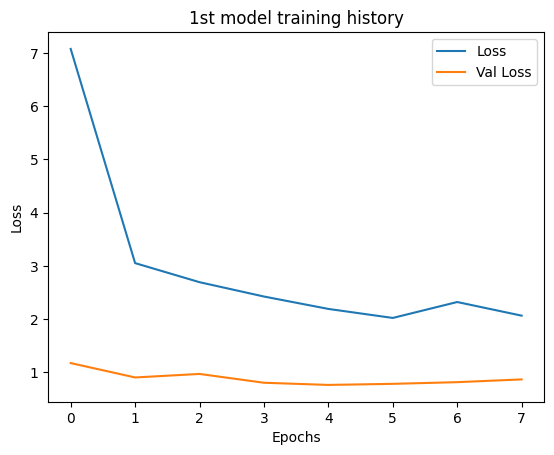

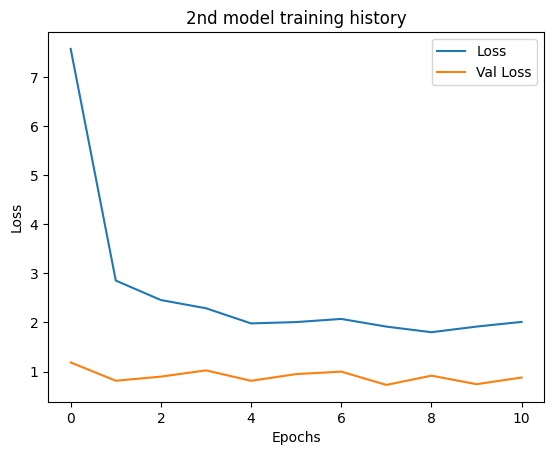

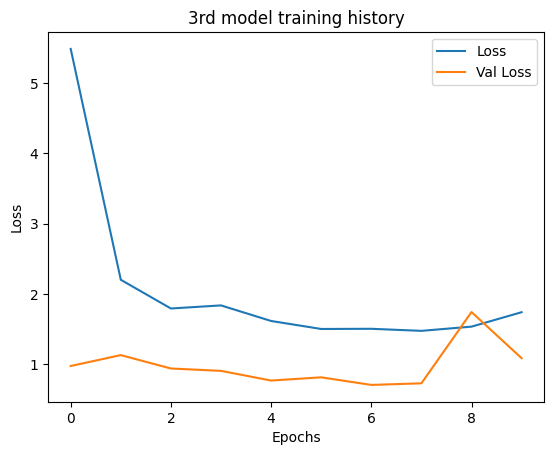

In [99]:
# 1st model
plt.plot(history_bert.history["loss"])
plt.plot(history_bert.history["val_loss"])
plt.title("1st model training history")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss","Val Loss"])
plt.show()

# 2nd model
plt.plot(history_bert_num.history["loss"])
plt.plot(history_bert_num.history["val_loss"])
plt.title("2nd model training history")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss","Val Loss"])
plt.show()

# 3rd model
plt.plot(history_bert_num_bin.history["loss"])
plt.plot(history_bert_num_bin.history["val_loss"])
plt.title("3rd model training history")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss","Val Loss"])
plt.show()

# Results and conclusions

In [105]:
bert_text_model.load_weights('training_bert_text/cp.ckpt')
bert_num_model.load_weights('training_bert_num/cp.ckpt')
bert_num_binary_model.load_weights('training_bert_num_bin/cp.ckpt')

In [106]:
predictions_bert_text = bert_text_model.predict(X_val_dict['input_ids'])
bert_text_mae = mean_absolute_error(y_val, predictions_bert_text)
print(bert_text_mae)

5/5 [==============================] - 6s 1s/step
0.7107680439949036


In [107]:
predictions_bert_num = bert_num_model.predict([X_val_dict['input_ids'], X_val_dict['numerical_features']])
bert_num_mae = mean_absolute_error(y_val, predictions_bert_num)
print(bert_num_mae)

5/5 [==============================] - 6s 1s/step
0.6780009236600664


In [103]:
predictions_bert_num_bin = bert_num_binary_model.predict([X_val_dict['input_ids'], X_val_dict['numerical_features'], X_val_dict['binary_features']])
bert_num_bin_mae = mean_absolute_error(y_val, predictions_bert_num_bin)
print(bert_num_bin_mae)

5/5 [==============================] - 9s 1s/step
0.6744683881600698


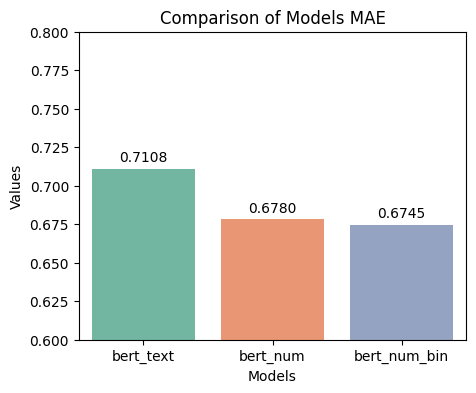

In [111]:
# Create a data frame for the metrics and values
mae_results = pd.DataFrame({'Models': ['bert_text', 'bert_num', 'bert_num_bin'],
                     'Values': [bert_text_mae, bert_num_mae, bert_num_bin_mae]})

# Create a bar plot using Seaborn
plt.figure(figsize=(5, 4))
sns.barplot(x='Models', y='Values', data=mae_results, palette='Set2')
plt.xlabel('Models')
plt.ylabel('Values')
plt.title('Comparison of Models MAE')

plt.ylim(0.6, 0.8)  # Set the y-axis range as needed

# Add value labels to the bars
for index, row in mae_results.iterrows():
    plt.text(index, row['Values'] + 0.005, f'{row["Values"]:.4f}', ha='center', fontsize=10)

plt.show()